In [131]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.linear_model import LinearRegression

In [18]:
def collect_data(
    df, num_groups, model_behavior_key, n_samples, collect_remaining_masks=True
):
    """Collect data for fitting and evaluating attribution scores from a data frame."""

    model_behavior_array = []
    if collect_remaining_masks:
        remaining_mask_array = []

    for _, row in df.iterrows():
        if collect_remaining_masks:
            remaining_idx = row["remaining_idx"]
            remaining_mask = np.zeros(num_groups)
            remaining_mask[remaining_idx] = 1
            remaining_mask_array.append(remaining_mask)

        if n_samples is None:
            model_behavior = [row[model_behavior_key]]
        else:
            model_behavior = [
                row[f"generated_image_{i}_{model_behavior_key}"]
                for i in range(n_samples)
            ]
        model_behavior_array.append(model_behavior)

    model_behavior_array = np.stack(model_behavior_array)
    if collect_remaining_masks:
        remaining_mask_array = np.stack(remaining_mask_array)
        return remaining_mask_array, model_behavior_array
    else:
        return model_behavior_array

In [19]:
test_db = "/gscratch/cse/clin25/diffusion-attr/seed42/artbench_post_impressionism/retrain_artist_shapley.jsonl"
test_df = pd.read_json(test_db, lines=True)
test_df["subset_seed"] = (
    test_df["exp_name"].str.split("seed_", expand=True)[1].astype(int)
)
test_df = test_df.sort_values(by="subset_seed")

test_size = 150
test_subset_seeds = [i for i in range(test_size)]
test_df = test_df[test_df["subset_seed"].isin(test_subset_seeds)]

In [127]:
def analyze_corr(model_behavior_key, df=test_df, num_groups=258, n_samples=50):
    x_test, y_test_all = collect_data(
        df=df,
        num_groups=num_groups,
        model_behavior_key=model_behavior_key,
        n_samples=n_samples,
    )
    subset_size_test = np.sum(x_test, axis=1)
    subset_size_test_features = subset_size_test.reshape(-1, 1)
    num_model_behaviors = y_test_all.shape[-1]
    
    spearman_list = []
    pearson_list = []
    linregress_list = []
    for k in range(num_model_behaviors):
        y_test = y_test_all[:, k]
        spearman_list.append(spearmanr(subset_size_test, y_test))
        pearson_list.append(pearsonr(subset_size_test, y_test))
        linregress = LinearRegression().fit(subset_size_test_features, y_test)
        linregress_list.append(
            {
                "score": linregress.score(subset_size_test_features, y_test),
                "prediction": linregress.predict(subset_size_test_features),
            }
        )

    # Plot examples.
    if n_samples is not None:
        nrows = 2
        ncols = 5
        fig, axes = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(5.5 * ncols, 5 * nrows),
            sharey=False,
            sharex=True,
        )
        counter = 0
        for i in range(nrows):
            for j in range(ncols):
                axis = axes[i, j]
                y_test = y_test_all[:, counter]
                axis.scatter(subset_size_test, y_test)
                axis.plot(subset_size_test, linregress_list[counter]["prediction"])
                axis.set_xlabel("subset size")
                axis.set_ylabel(model_behavior_key)
                axis.set_title(f"Generated image {counter}")
                counter += 1
        plt.show()
    else:
        fig, axis = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(5.5, 5),
            sharey=False,
            sharex=True,
        )
        y_test = y_test_all[:, 0]
        axis.scatter(subset_size_test, y_test)
        axis.plot(subset_size_test, linregress_list[0]["prediction"])
        axis.set_xlabel("subset size")
        axis.set_ylabel(model_behavior_key)
        plt.show()

    # Aggregate statistics.
    stats = {
        "spearman_corr": np.mean([spearman.statistic for spearman in spearman_list]),
        "spearman_pval": np.mean([spearman.pvalue for spearman in spearman_list]),
        "pearson_corr": np.mean([pearson.statistic for pearson in pearson_list]),
        "pearson_pval": np.mean([pearson.pvalue for pearson in pearson_list]),
        "linregress_score": np.mean([linregress["score"] for linregress in linregress_list]), 
    }
    return stats

ssim


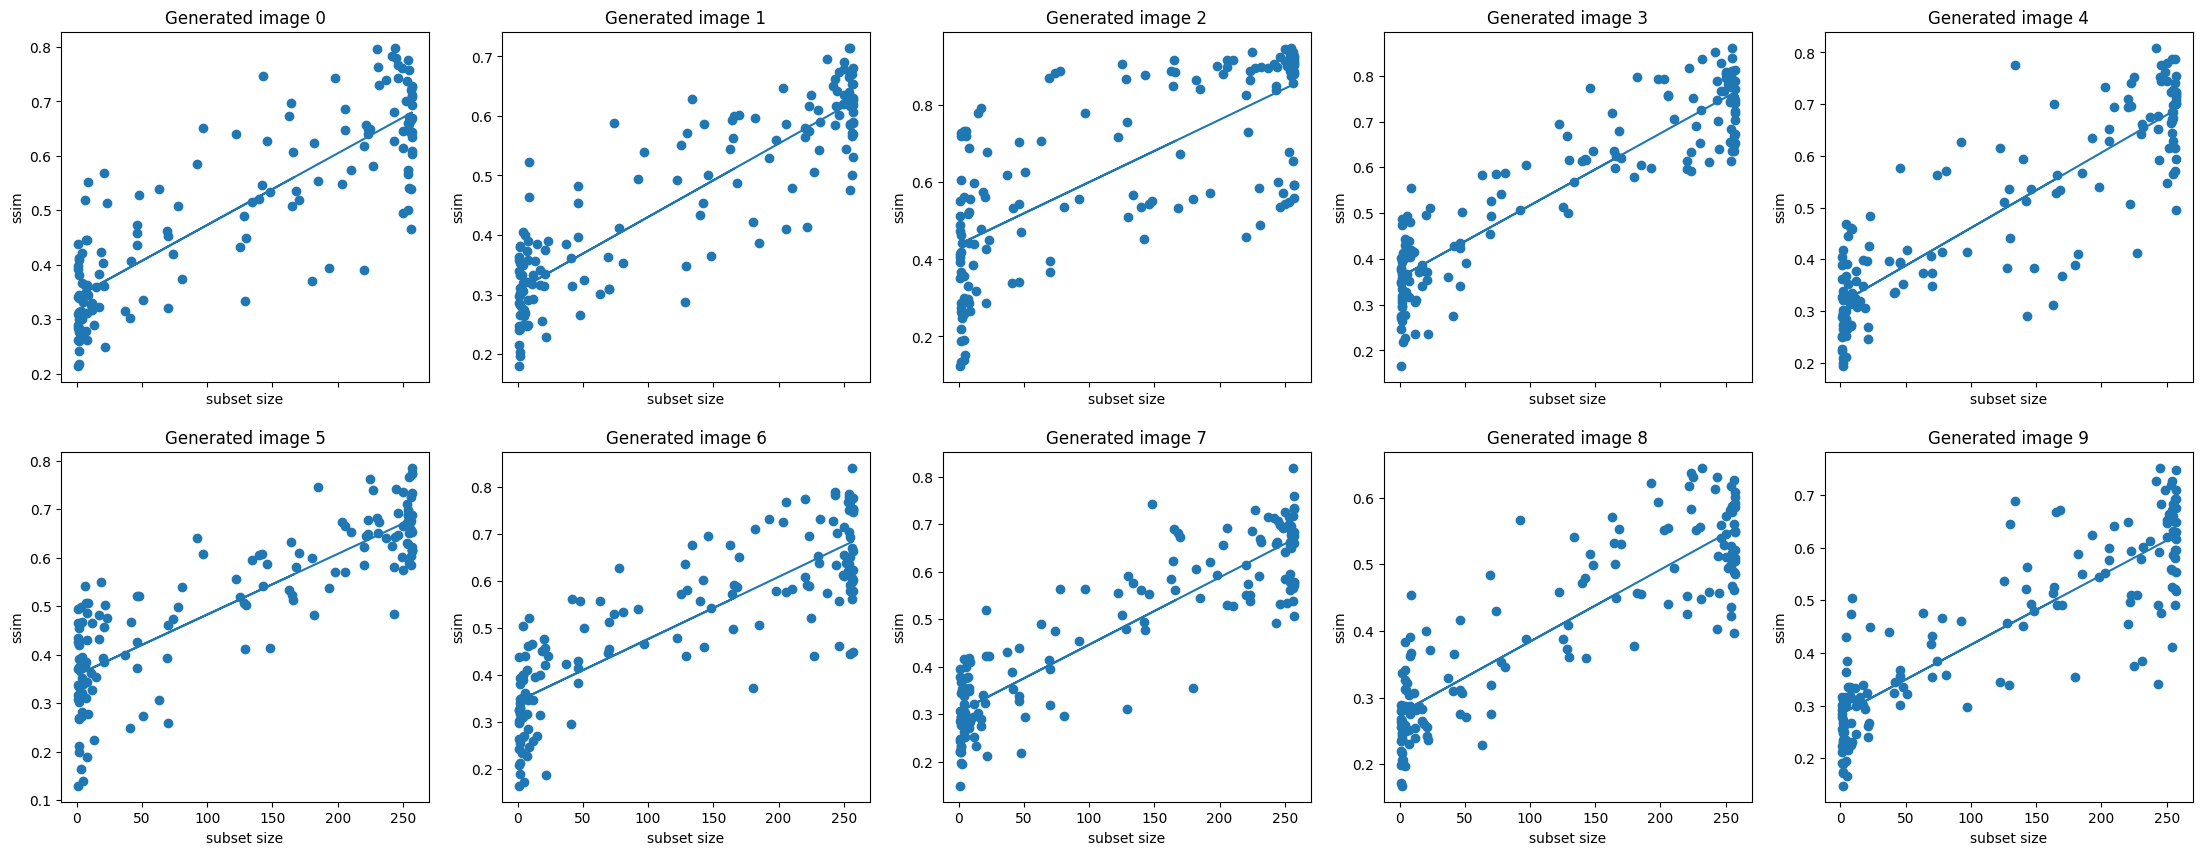

spearman_corr: 0.8287947831565796
spearman_pval: 2.787517407584236e-16
pearson_corr: 0.8503902080882969
pearson_pval: 2.4487592438247236e-15
linregress_score: 0.7273572372709707
----------------------------------------------------------------------------------------------------
simple_loss


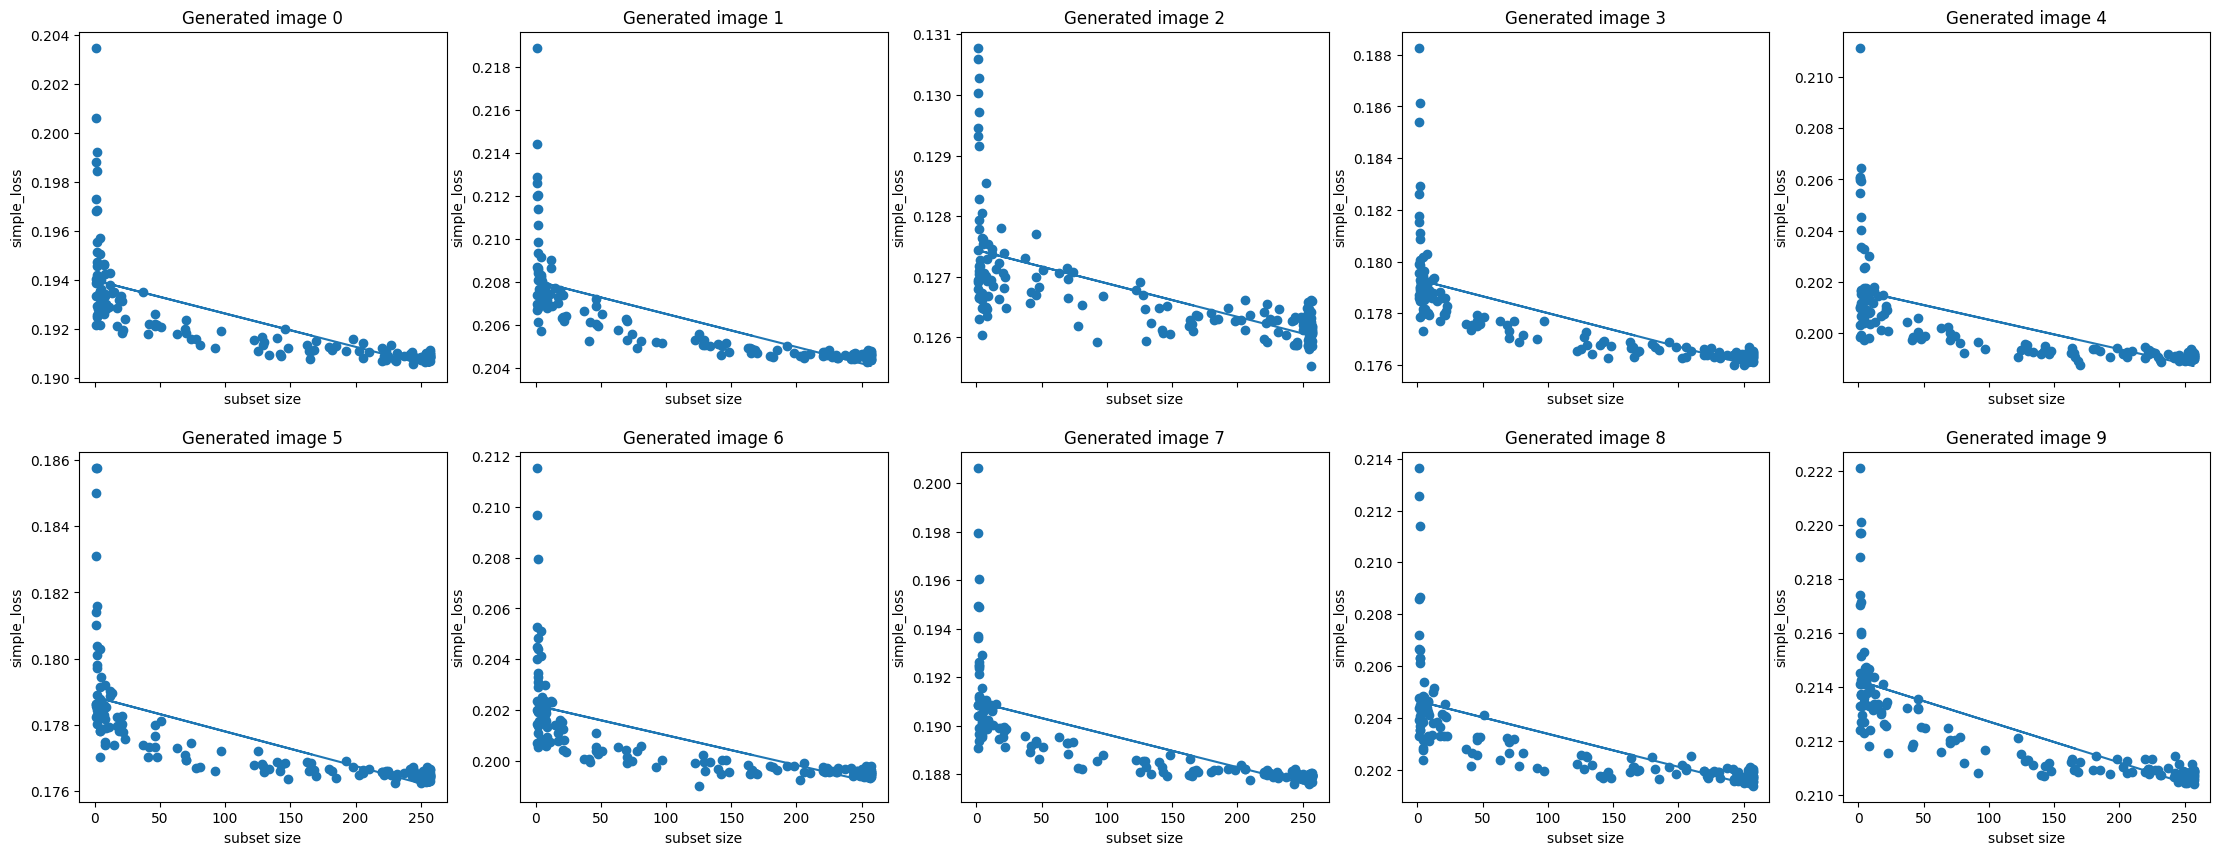

spearman_corr: -0.8731384211454634
spearman_pval: 1.7259184402389965e-29
pearson_corr: -0.6959368027495745
pearson_pval: 1.498643561913112e-17
linregress_score: 0.4871968267252232
----------------------------------------------------------------------------------------------------
nrmse


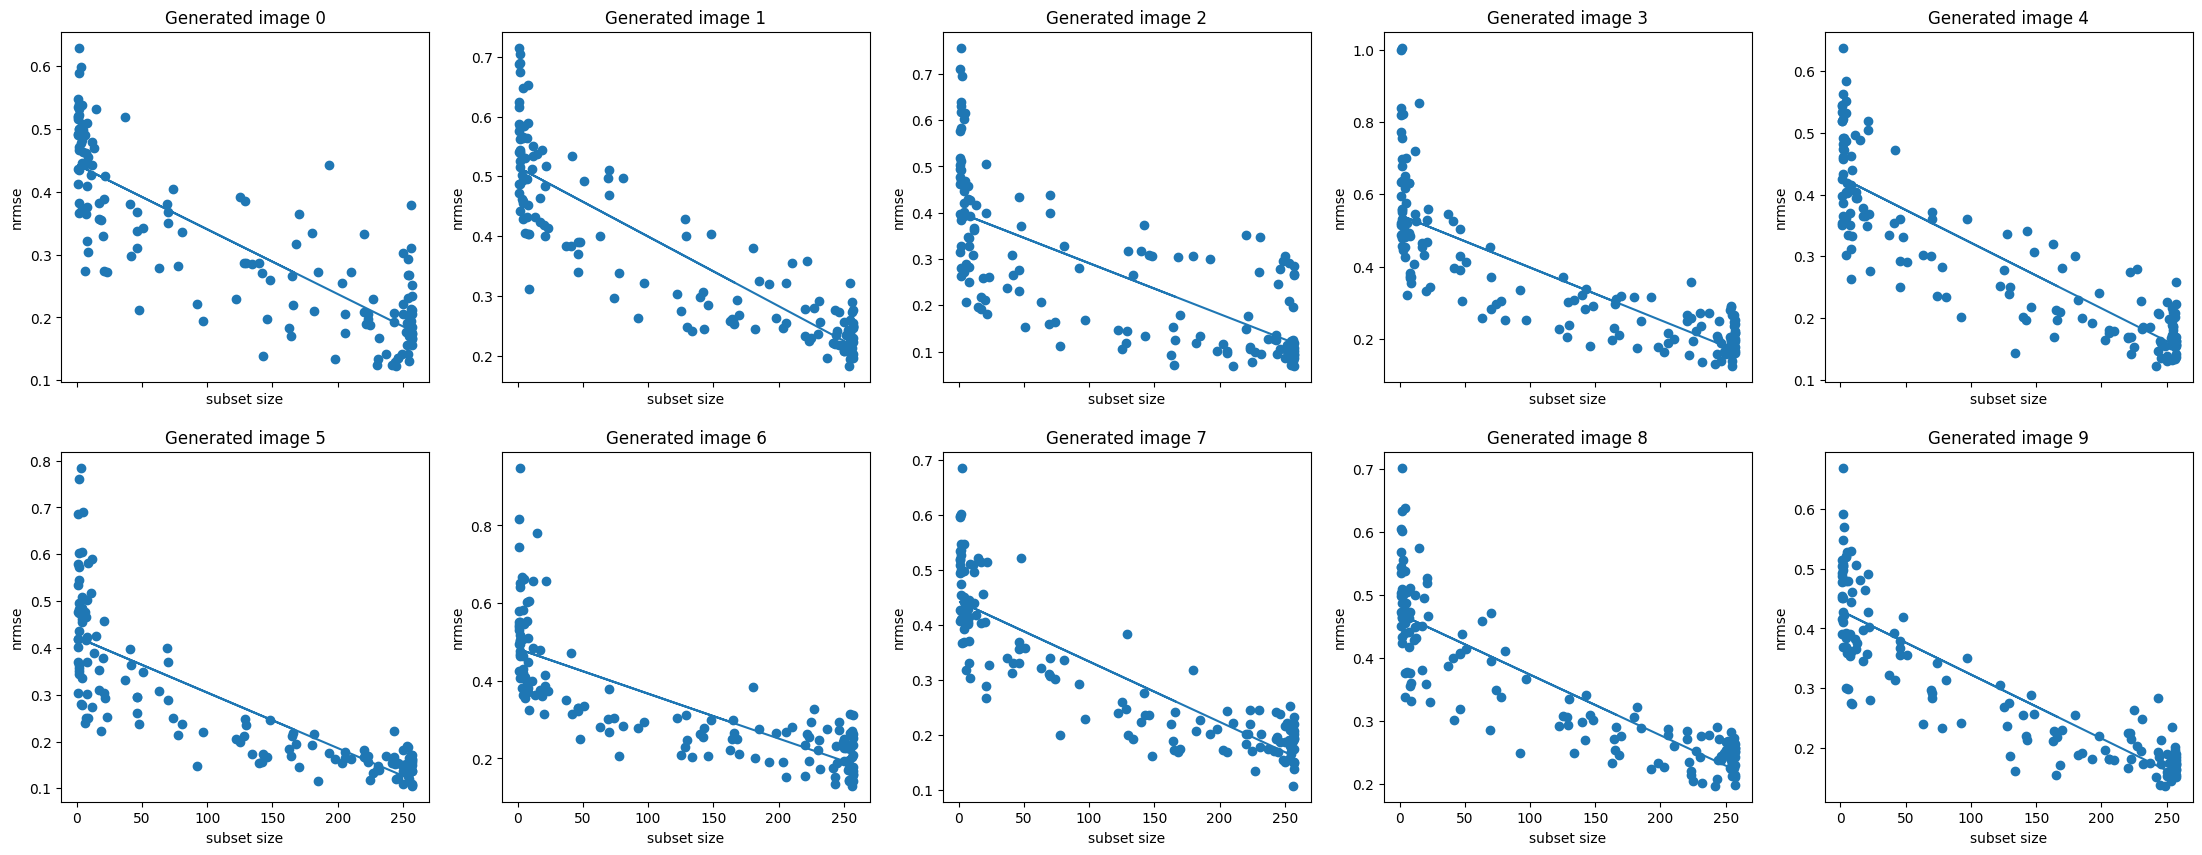

spearman_corr: -0.85159055968441
spearman_pval: 7.038539067139352e-18
pearson_corr: -0.8206886747405701
pearson_pval: 3.7010726595270156e-16
linregress_score: 0.6765991659961366
----------------------------------------------------------------------------------------------------
clip_similarity


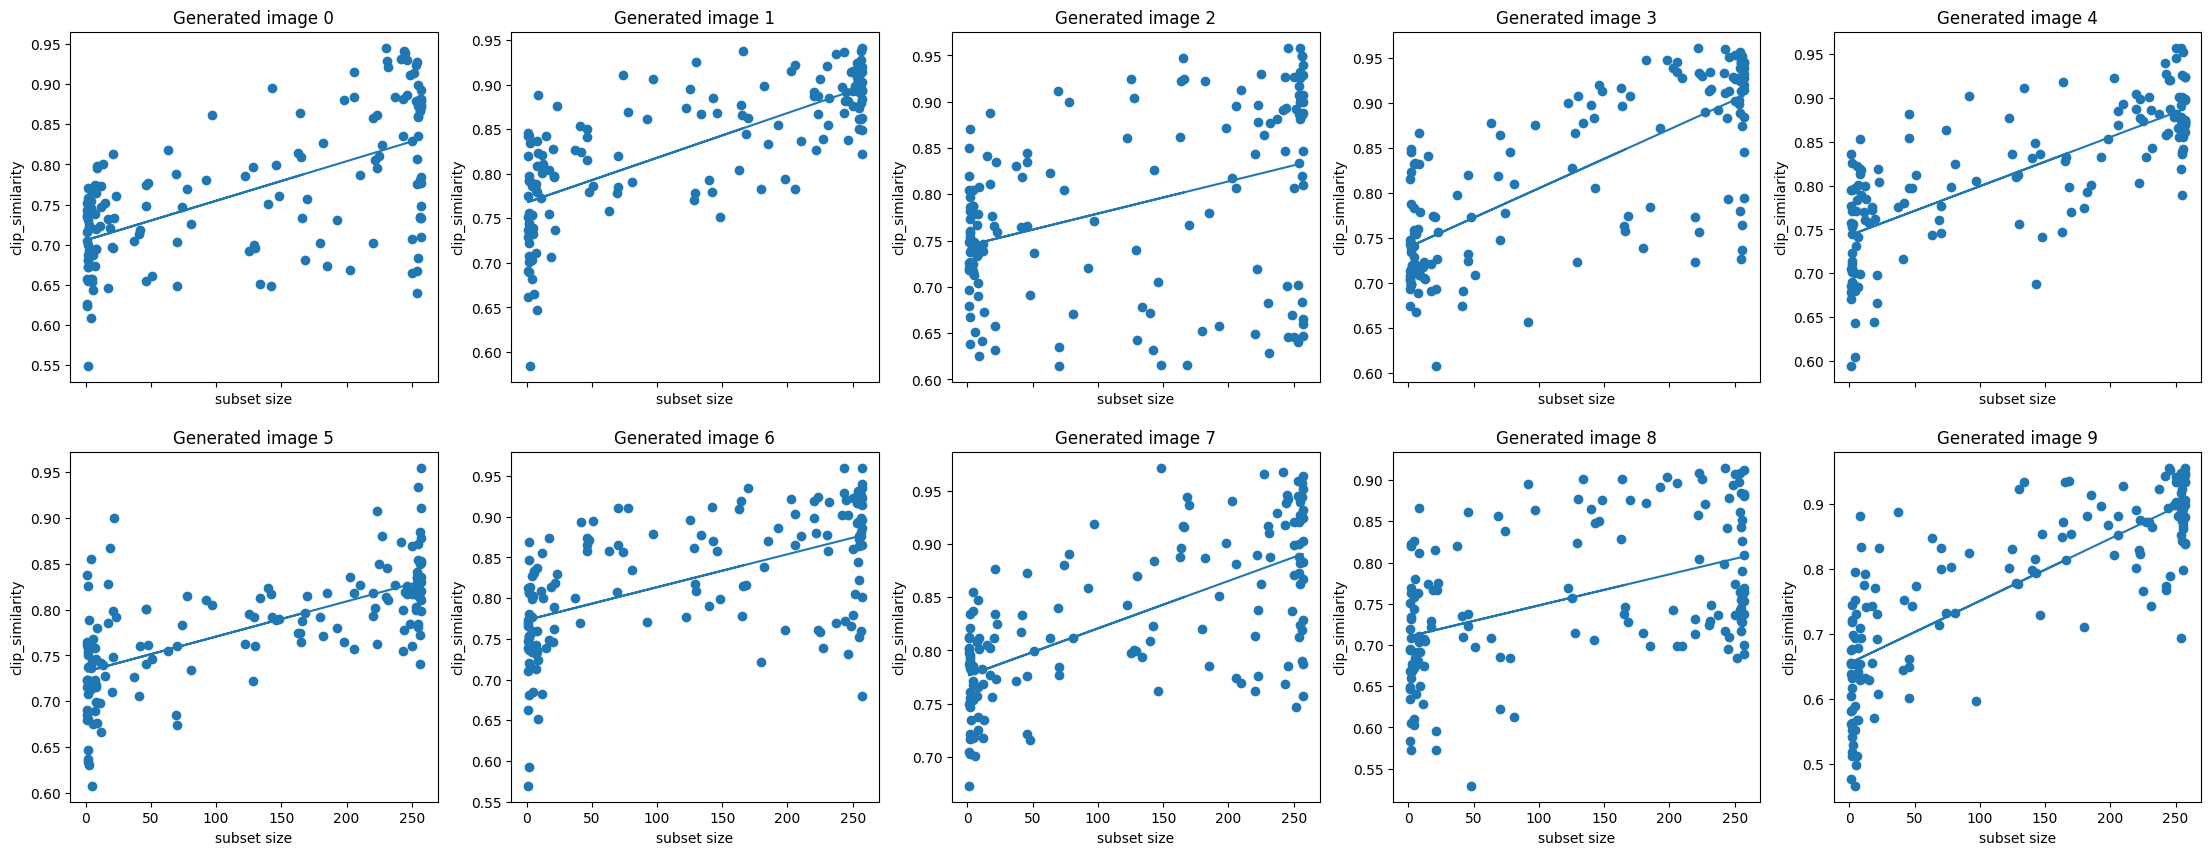

spearman_corr: 0.6359393668343917
spearman_pval: 0.018702770635397322
pearson_corr: 0.6370063871777529
pearson_pval: 0.004618704335560268
linregress_score: 0.43721727742354316
----------------------------------------------------------------------------------------------------


In [125]:
for model_behavior_key in ["ssim", "simple_loss", "nrmse", "clip_similarity"]:
    print(model_behavior_key)
    stats = analyze_corr(model_behavior_key)
    for key, val in stats.items():
        print(f"{key}: {val}")
    print("-" * 100)

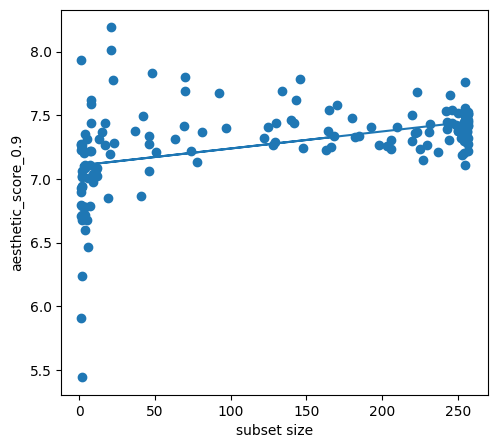

spearman_corr: 0.526874048334877
spearman_pval: 4.3336187049615985e-12
pearson_corr: 0.41157934172079413
pearson_pval: 1.6730822013215787e-07
linregress_score: 0.1693975545313221


In [129]:
stats = analyze_corr("aesthetic_score_0.9", n_samples=None)
for key, val in stats.items():
    print(f"{key}: {val}")

In [145]:
def lds_with_noises(model_behavior_key, df=test_df, num_groups=258, n_samples=50):
    x_test, y_test_all = collect_data(
        df=df,
        num_groups=num_groups,
        model_behavior_key=model_behavior_key,
        n_samples=n_samples,
    )
    num_model_behaviors = y_test_all.shape[-1]

    lds_list_dict = {}
    for pos_ratio in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        lds_list = []
        for _ in range(50):
            num_pos_attrs = math.floor(num_groups * pos_ratio)
            num_neg_attrs = num_groups - num_pos_attrs
            attrs = np.abs(np.random.normal(size=num_groups))
            if num_neg_attrs > 0:
                attrs[:num_neg_attrs] = -attrs[:num_neg_attrs]
            np.random.shuffle(attrs)
            lds = []
            for k in range(num_model_behaviors):
                y_test = y_test_all[: ,k]
                lds.append(
                    spearmanr(x_test @ attrs, y_test).statistic * 100
                )
            lds_list.append(np.mean(lds))
        lds_list_dict[pos_ratio] = lds_list
    return lds_list_dict

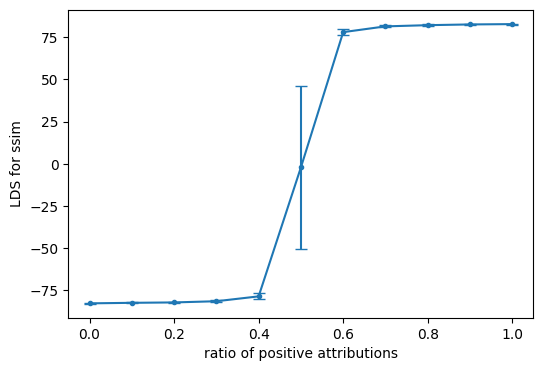

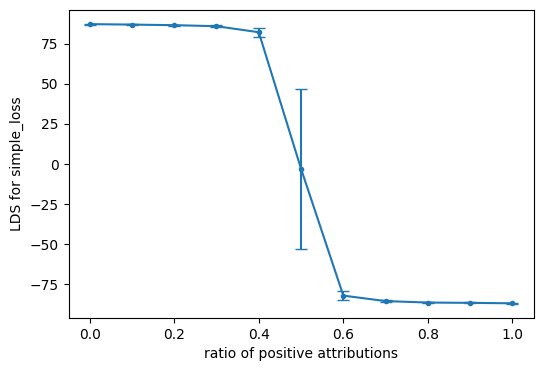

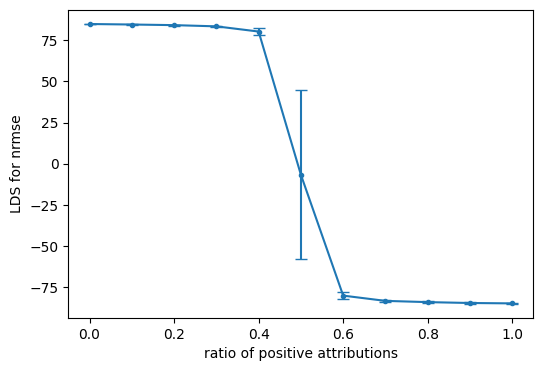

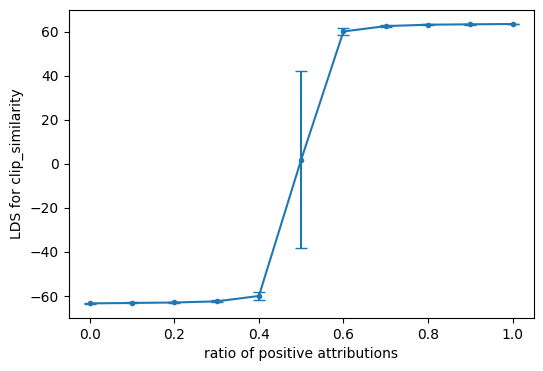

In [172]:
for model_behavior_key in ["ssim", "simple_loss", "nrmse", "clip_similarity"]:
    lds_list_dict = lds_with_noises(model_behavior_key)
    pos_ratios = [key for key in lds_list_dict.keys()]
    pos_ratios = sorted(pos_ratios)
    lds_mean = [np.mean(lds_list_dict[pos_ratio]) for pos_ratio in pos_ratios]
    lds_std = [np.std(lds_list_dict[pos_ratio]) for pos_ratio in pos_ratios]
    plt.figure(figsize=(6, 4))
    plt.errorbar(x=pos_ratios, y=lds_mean, yerr=lds_std, capsize=4, marker="o", ms=3)
    plt.xlabel("ratio of positive attributions")
    plt.ylabel(f"LDS for {model_behavior_key}")
    plt.show()

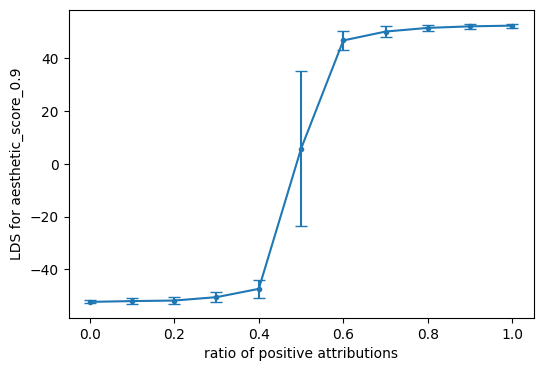

In [173]:
model_behavior_key = "aesthetic_score_0.9"
lds_list_dict = lds_with_noises(model_behavior_key, n_samples=None)
pos_ratios = [key for key in lds_list_dict.keys()]
pos_ratios = sorted(pos_ratios)
lds_mean = [np.mean(lds_list_dict[pos_ratio]) for pos_ratio in pos_ratios]
lds_std = [np.std(lds_list_dict[pos_ratio]) for pos_ratio in pos_ratios]
plt.figure(figsize=(6, 4))
plt.errorbar(x=pos_ratios, y=lds_mean, yerr=lds_std, capsize=4, marker="o", ms=3)
plt.xlabel("ratio of positive attributions")
plt.ylabel(f"LDS for {model_behavior_key}")
plt.show()

In [175]:
def analyze_residual_corr(model_behavior_key, df=test_df, num_groups=258, n_samples=50):
    x_test, y_test_all = collect_data(
        df=df,
        num_groups=num_groups,
        model_behavior_key=model_behavior_key,
        n_samples=n_samples,
    )
    subset_size_test = np.sum(x_test, axis=1)
    subset_size_test_features = subset_size_test.reshape(-1, 1)
    num_model_behaviors = y_test_all.shape[-1]
    
    spearman_list = []
    pearson_list = []
    for k in range(num_model_behaviors):
        y_test = y_test_all[:, k]
        linregress = LinearRegression().fit(subset_size_test_features, y_test)
        residual = y_test - linregress.predict(subset_size_test_features)
        
        spearman_list.append(spearmanr(subset_size_test, residual))
        pearson_list.append(pearsonr(subset_size_test, residual))

    # Plot examples.
    if n_samples is not None:
        nrows = 2
        ncols = 5
        fig, axes = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(5.5 * ncols, 5 * nrows),
            sharey=False,
            sharex=True,
        )
        counter = 0
        for i in range(nrows):
            for j in range(ncols):
                axis = axes[i, j]
                y_test = y_test_all[:, counter]
                axis.scatter(subset_size_test, residual, color="tab:orange")
                axis.set_xlabel("subset size")
                axis.set_ylabel(f"residual for {model_behavior_key}")
                axis.set_title(f"Generated image {counter}")
                counter += 1
        plt.show()
    else:
        fig, axis = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(5.5, 5),
            sharey=False,
            sharex=True,
        )
        y_test = y_test_all[:, 0]
        axis.scatter(subset_size_test, residual, color="tab:orange")
        axis.set_xlabel("subset size")
        axis.set_ylabel(f"residual for {model_behavior_key}")
        plt.show()

    # Aggregate statistics.
    stats = {
        "spearman_corr": np.mean([spearman.statistic for spearman in spearman_list]),
        "spearman_pval": np.mean([spearman.pvalue for spearman in spearman_list]),
        "pearson_corr": np.mean([pearson.statistic for pearson in pearson_list]),
        "pearson_pval": np.mean([pearson.pvalue for pearson in pearson_list]),
    }
    return stats

ssim


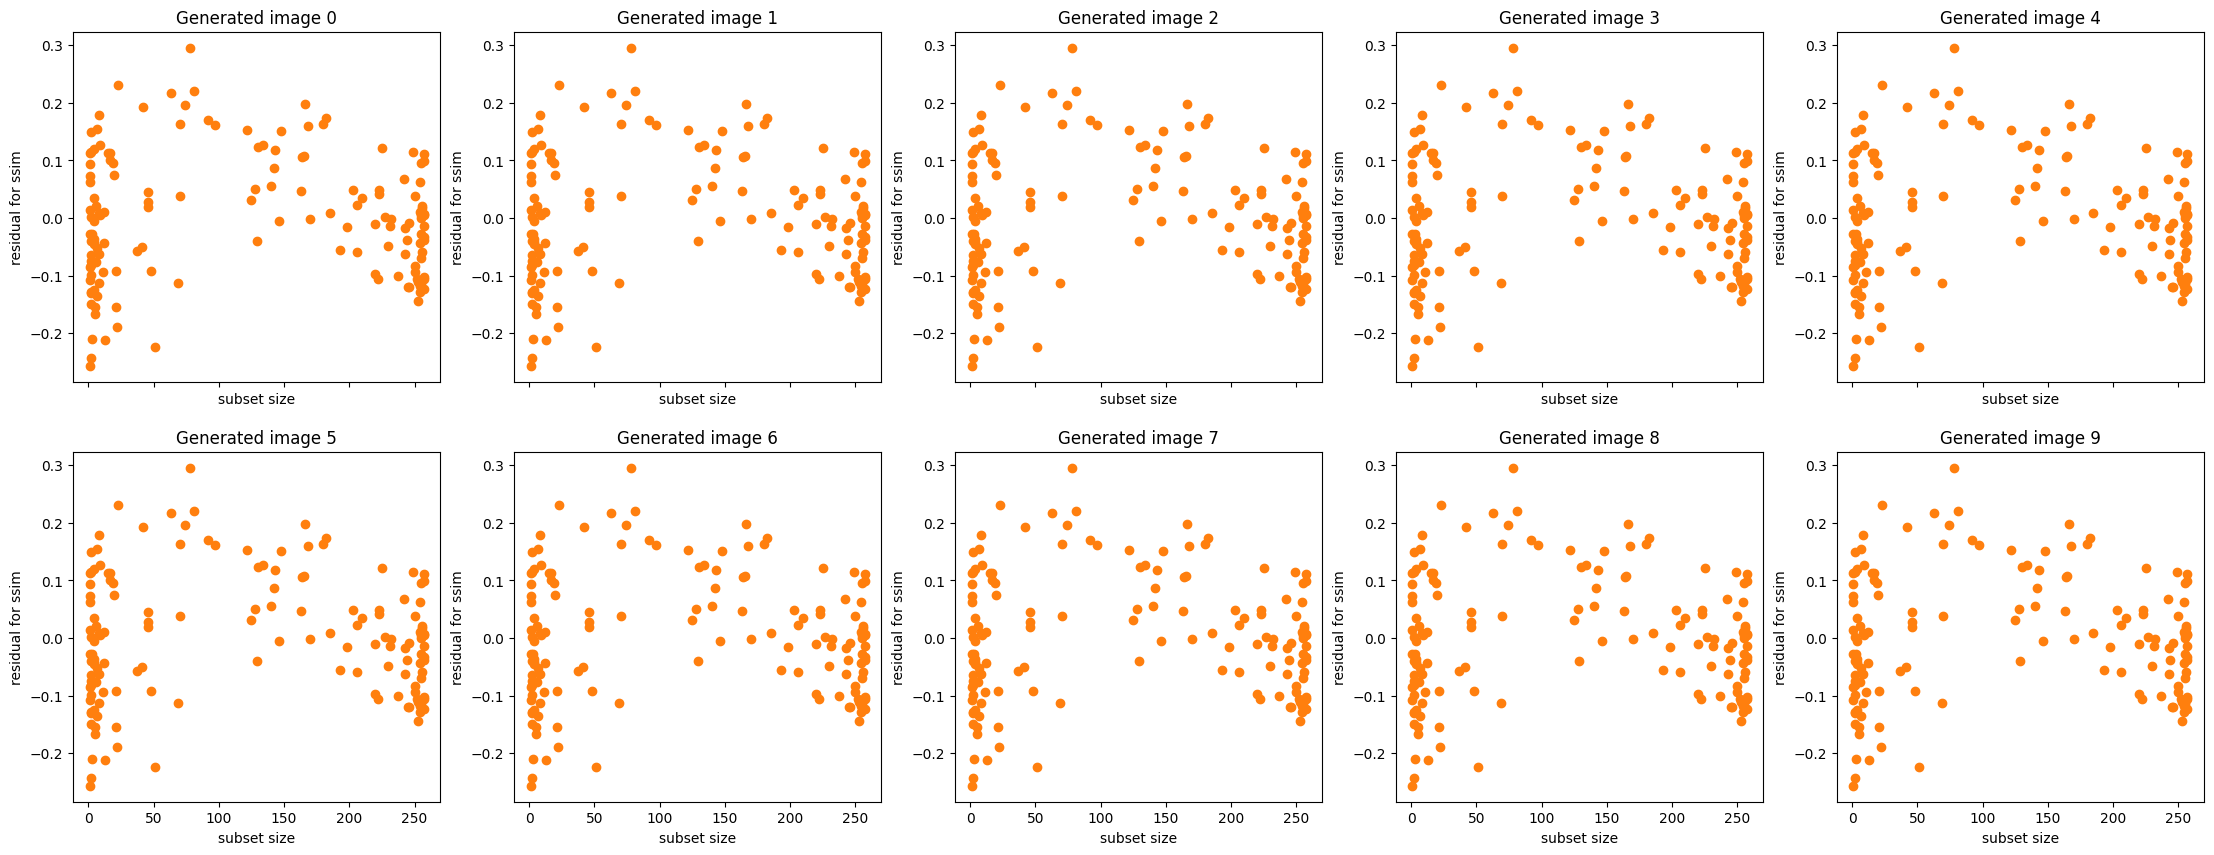

spearman_corr: 0.02604690779802989
spearman_pval: 0.5918868362868293
pearson_corr: -4.3971770669060104e-16
pearson_pval: 0.9999999999999966
----------------------------------------------------------------------------------------------------
simple_loss


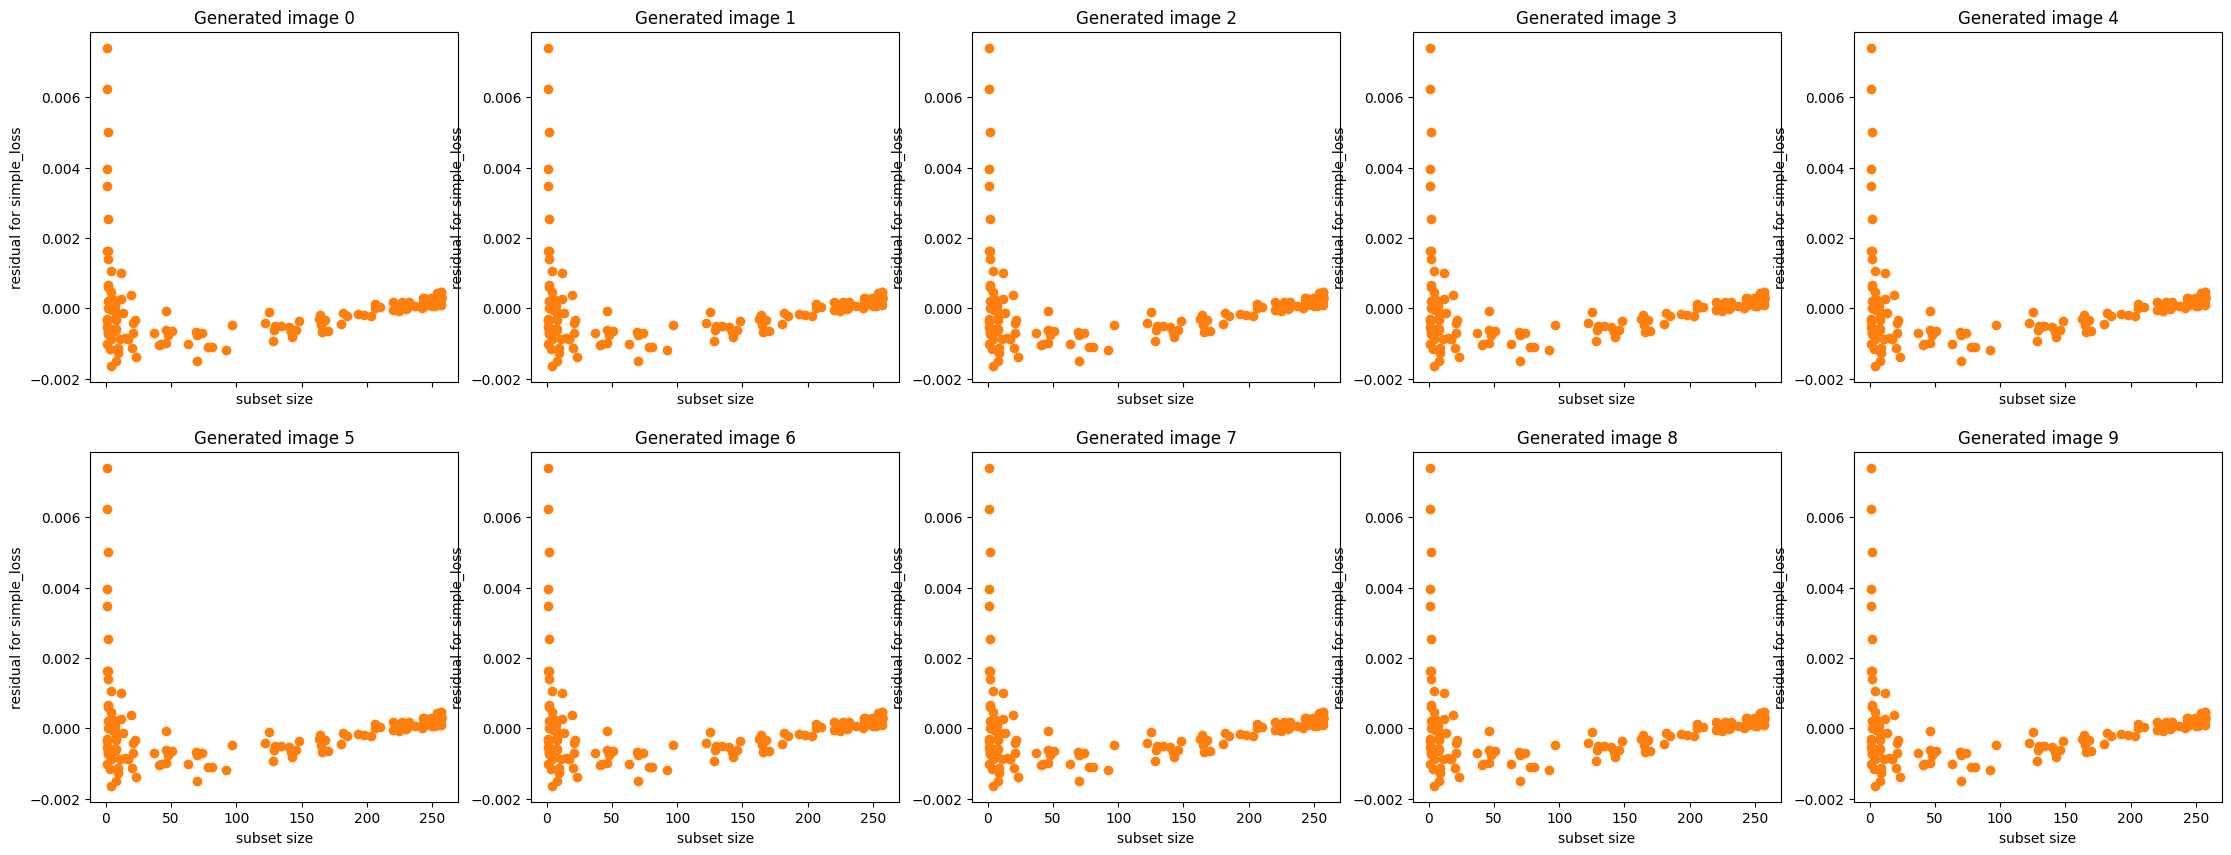

spearman_corr: 0.24117210848132875
spearman_pval: 0.028947814141775163
pearson_corr: 3.1515588749808645e-16
pearson_pval: 0.9999999999999932
----------------------------------------------------------------------------------------------------
nrmse


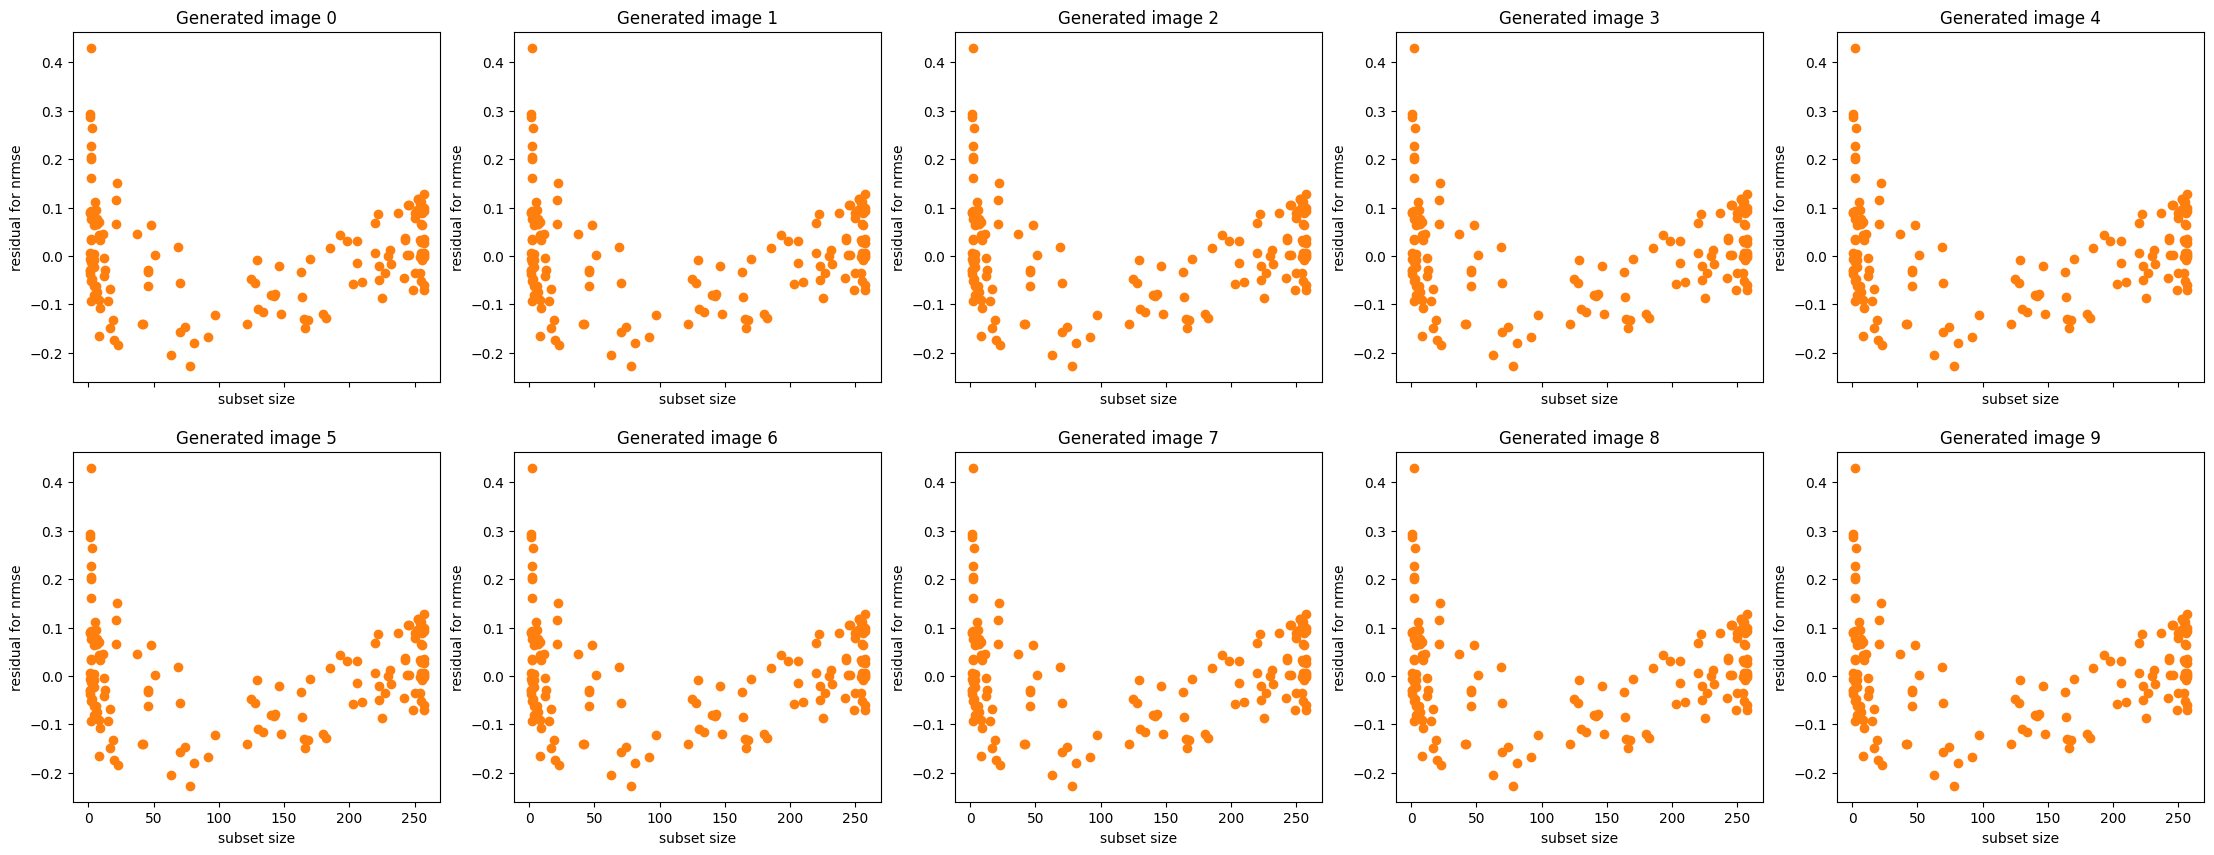

spearman_corr: 0.019155892874478084
spearman_pval: 0.6346163220151614
pearson_corr: 3.932965064734617e-16
pearson_pval: 0.9999999999999973
----------------------------------------------------------------------------------------------------
clip_similarity


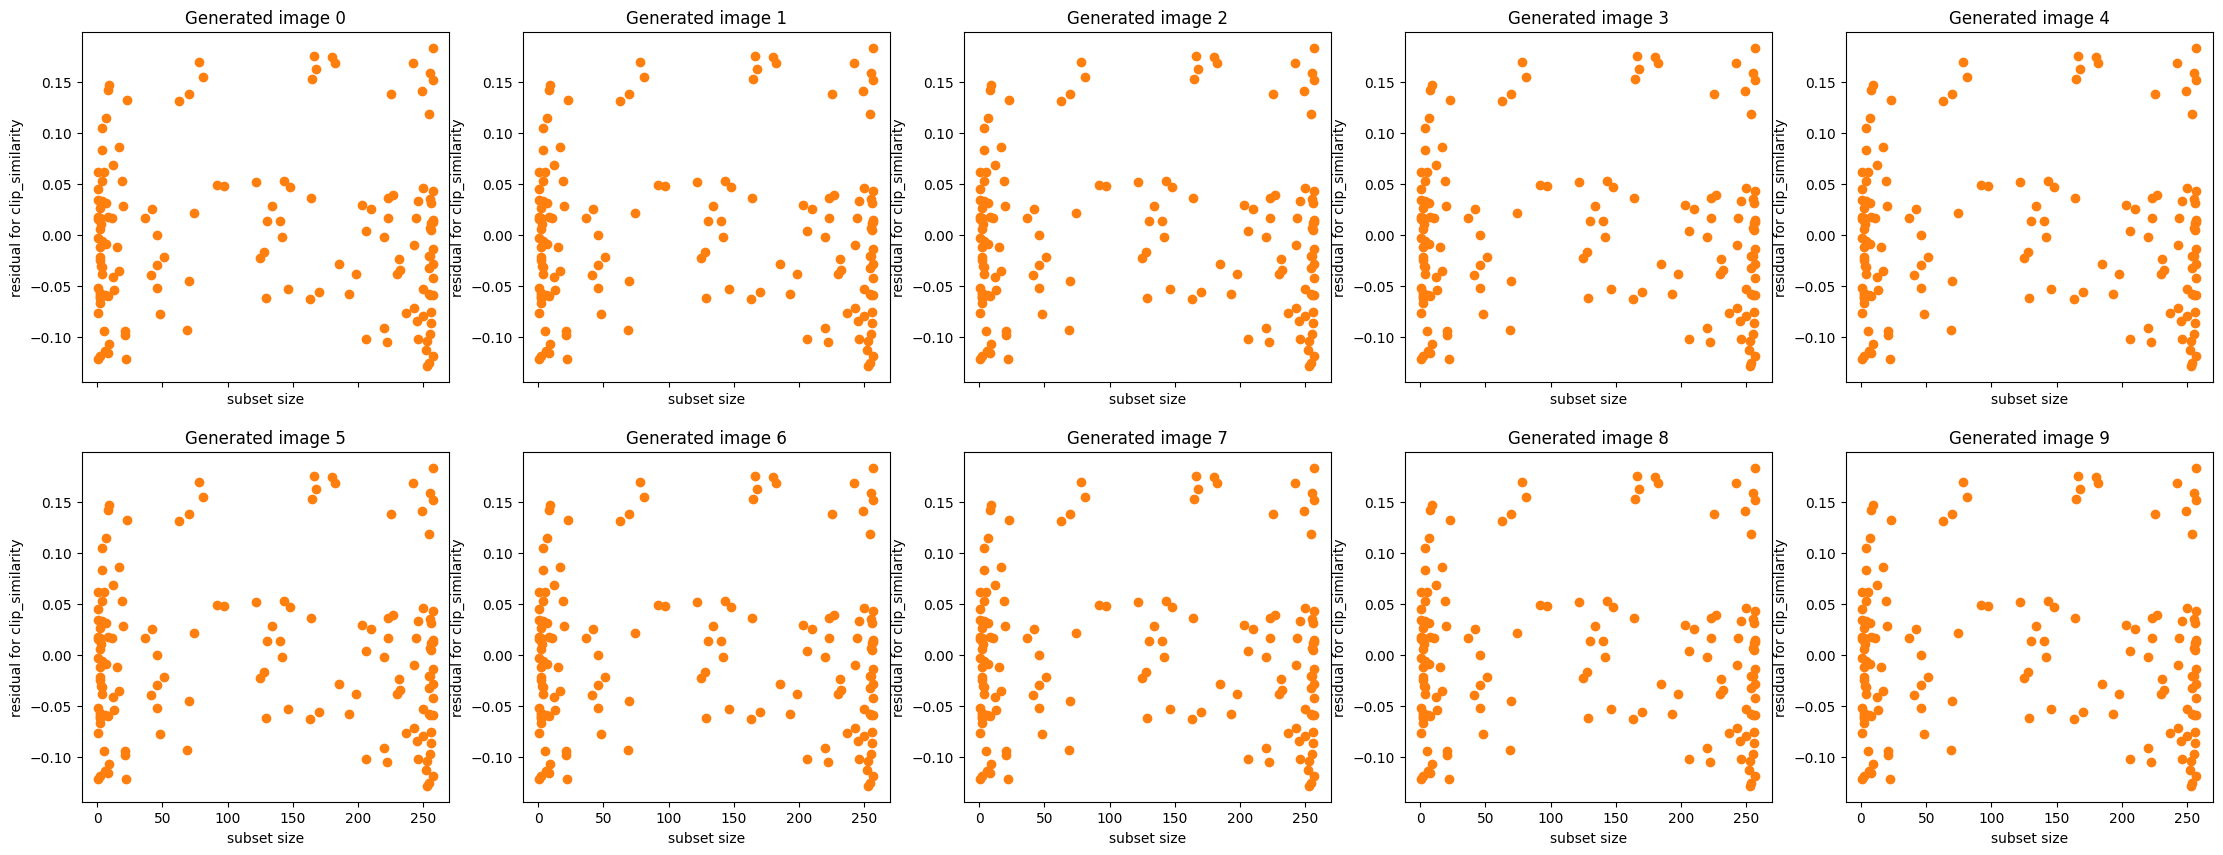

spearman_corr: 0.00576272393470263
spearman_pval: 0.605425913645067
pearson_corr: -2.49592013723543e-16
pearson_pval: 0.9999999999999986
----------------------------------------------------------------------------------------------------


In [176]:
for model_behavior_key in ["ssim", "simple_loss", "nrmse", "clip_similarity"]:
    print(model_behavior_key)
    stats = analyze_residual_corr(model_behavior_key)
    for key, val in stats.items():
        print(f"{key}: {val}")
    print("-" * 100)

aesthetic_score_0.9


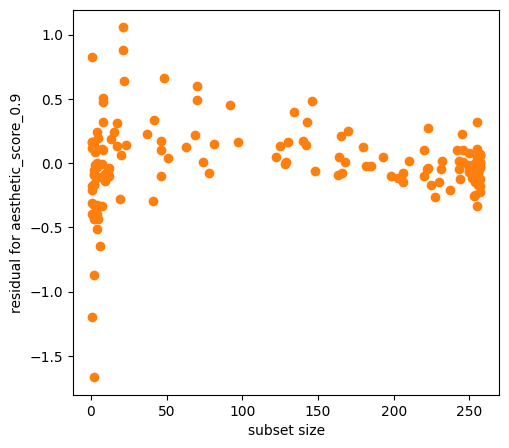

spearman_corr: 0.010487348062811193
spearman_pval: 0.8986457628746232
pearson_corr: 6.938893903907228e-18
pearson_pval: 0.9999999999999991
----------------------------------------------------------------------------------------------------


In [177]:
model_behavior_key = "aesthetic_score_0.9"
print(model_behavior_key)
stats = analyze_residual_corr(model_behavior_key, n_samples=None)
for key, val in stats.items():
    print(f"{key}: {val}")
print("-" * 100)

In [178]:
def residual_lds_with_noises(model_behavior_key, df=test_df, num_groups=258, n_samples=50):
    x_test, y_test_all = collect_data(
        df=df,
        num_groups=num_groups,
        model_behavior_key=model_behavior_key,
        n_samples=n_samples,
    )
    num_model_behaviors = y_test_all.shape[-1]
    residual_all = np.zeros(shape=y_test_all.shape)
    for k in range(num_model_behaviors):
        y_test = y_test_all[:, k]
        linregress = LinearRegression().fit(subset_size_test_features, y_test)
        residual = y_test - linregress.predict(subset_size_test_features)
        residual_all[:, k] = residual

    lds_list_dict = {}
    for pos_ratio in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        lds_list = []
        for _ in range(50):
            num_pos_attrs = math.floor(num_groups * pos_ratio)
            num_neg_attrs = num_groups - num_pos_attrs
            attrs = np.abs(np.random.normal(size=num_groups))
            if num_neg_attrs > 0:
                attrs[:num_neg_attrs] = -attrs[:num_neg_attrs]
            np.random.shuffle(attrs)
            lds = []
            for k in range(num_model_behaviors):
                residual = residual_all[:, k]
                lds.append(
                    spearmanr(x_test @ attrs, residual).statistic * 100
                )
            lds_list.append(np.mean(lds))
        lds_list_dict[pos_ratio] = lds_list
    return lds_list_dict

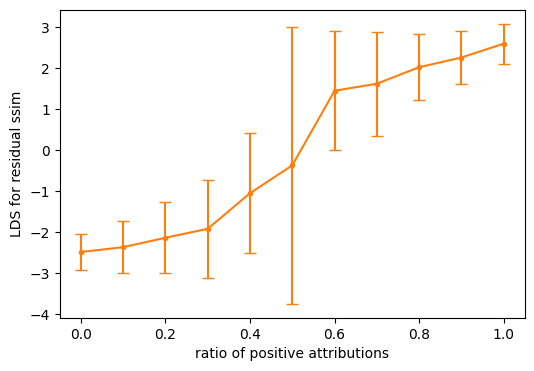

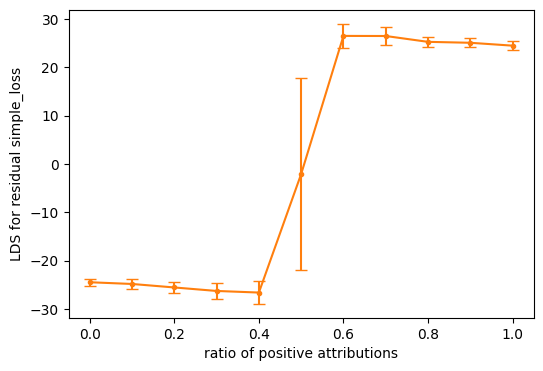

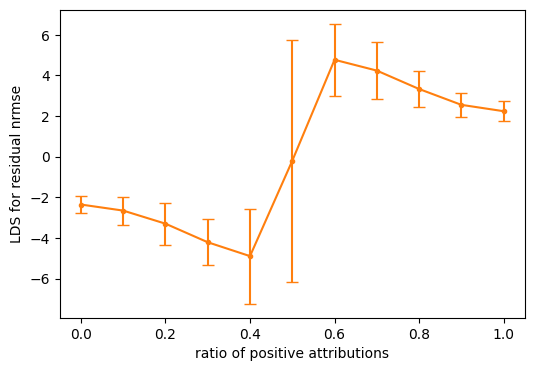

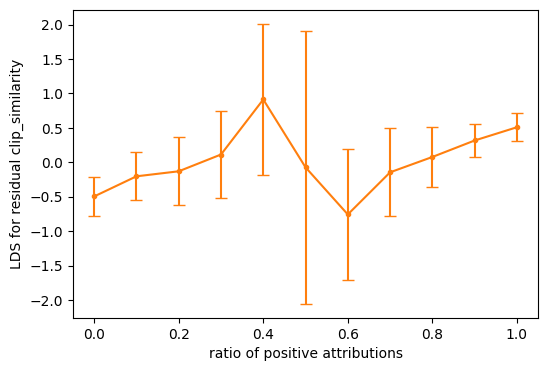

In [179]:
for model_behavior_key in ["ssim", "simple_loss", "nrmse", "clip_similarity"]:
    lds_list_dict = residual_lds_with_noises(model_behavior_key)
    pos_ratios = [key for key in lds_list_dict.keys()]
    pos_ratios = sorted(pos_ratios)
    lds_mean = [np.mean(lds_list_dict[pos_ratio]) for pos_ratio in pos_ratios]
    lds_std = [np.std(lds_list_dict[pos_ratio]) for pos_ratio in pos_ratios]
    plt.figure(figsize=(6, 4))
    plt.errorbar(x=pos_ratios, y=lds_mean, yerr=lds_std, capsize=4, marker="o", ms=3, color="tab:orange")
    plt.xlabel("ratio of positive attributions")
    plt.ylabel(f"LDS for residual {model_behavior_key}")
    plt.show()

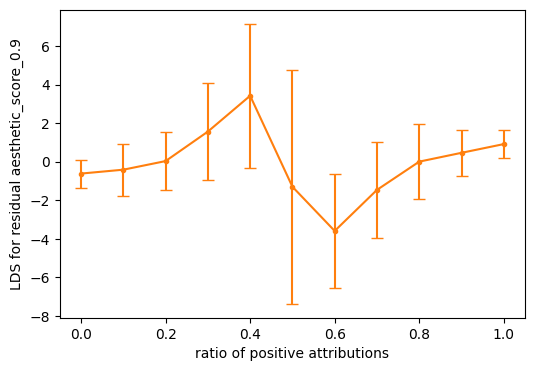

In [182]:
model_behavior_key = "aesthetic_score_0.9"
lds_list_dict = residual_lds_with_noises(model_behavior_key, n_samples=None)
pos_ratios = [key for key in lds_list_dict.keys()]
pos_ratios = sorted(pos_ratios)
lds_mean = [np.mean(lds_list_dict[pos_ratio]) for pos_ratio in pos_ratios]
lds_std = [np.std(lds_list_dict[pos_ratio]) for pos_ratio in pos_ratios]
plt.figure(figsize=(6, 4))
plt.errorbar(x=pos_ratios, y=lds_mean, yerr=lds_std, capsize=4, marker="o", ms=3, color="tab:orange")
plt.xlabel("ratio of positive attributions")
plt.ylabel(f"LDS for residual {model_behavior_key}")
plt.show()